In [528]:
## Import necessary libraries here (You can add libraries you want to use here)
import os
import random
import cv2
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

# Part 1: Epipolar Geometry (30 Points)


## Overview

In this problem, you will implement an algorithm for automatically estimating homography with RANSAC. In the file matches.mat, we provide the detected Harris corners row-column positions in variables r1 c1 for the first image; variables r2 c2 for the second image; and the corresponding matched pairs in the variable matches.

<!-- <img src="https://drive.google.com/uc?id=1Tr723u5OXmwkd4RDmu9z886ITJU9j1cL&export=download" width="800"/> -->

<img src="https://www.cs.umd.edu/class/spring2023/cmsc426-0201/hw_images/epipolar_geometry.jpg" width="800"/>


The outline of the normalized 8-point algorithm:

<img src="https://www.cs.umd.edu/class/spring2023/cmsc426-0201/hw_images/8pointalgo.jpg" width="700"/>



## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [529]:
# Download Data -- run this cell only one time per runtime
# !gdown 1cn3_SscjlLrf4BzUWe8MV-XqMqBY4Nj_
# Or download from https://drive.google.com/file/d/1cn3_SscjlLrf4BzUWe8MV-XqMqBY4Nj_/view and upload

# !unzip "/content/Part1_data.zip" -d "/content/"
# Load Matches
data = loadmat('Part1_data/matches.mat')
r1 = data['r1']
r2 = data['r2']
c1 = data['c1']
c2 = data['c2']
matches = data['matches']

In [530]:
# Load Keypoints
x1 = c1[matches[:,0]-1]
y1 = r1[matches[:,0]-1]
x2 = c2[matches[:,1]-1]
y2 = r2[matches[:,1]-1]

## Helper Functions

In [531]:
from scipy.ndimage import gaussian_filter as gf

def show_image(img, scale=1.0):
    plt.figure(figsize=scale* plt.figaspect(1))
    plt.imshow(img, interpolation='nearest')
    plt.gray()
    plt.axis('off')
    plt.show()


### Code (15 pt)

### Hint

*   For visualization, you can use cv2.line, cv2.circle or any other helper functions in opencv or matplotlib.


In [532]:
def normalize(x, y):
  """
  Function: find the transformation T to make coordinates zero mean and the variance as sqrt(2)
  Input: x, y - coordinates
  Output: normalized coordinates, transformation T
  """
  x = x.astype(np.float64)
  y = y.astype(np.float64)
    
  mean_x = np.mean(x)
  mean_y = np.mean(y)
  x -= mean_x
  y -= mean_y
  scale = np.sqrt(2) / np.mean(np.sqrt(x**2 + y**2))
  T = np.array([[scale, 0, -scale * mean_x],
                [0, scale, -scale * mean_y],
                [0, 0, 1]])
  x_norm = x * scale
  y_norm = y * scale
  norm_p = np.column_stack((x_norm, y_norm))
  # Check the standard deviation, which should be close to sqrt(2)
  # print(np.var(norm_p))
  return norm_p, T

def ransacF(x1, y1, x2, y2, num_iterations=1000, threshold=0.01):
  """
  Find normalization matrix
  Transform point set 1 and 2
  RANSAC based 8-point algorithm
  Input:
     x1, y1, x2, y2 - coordinates
     num_iterations - how many iterations
     threshold - threshold for inlier check
  Output:
     Best fundamental matrix
     corresponding inlier indices
  """
  # YOUR CODE HERE:
  max_inliers = []
  best_F = None
  # Hint:
  # for ... in num_iterations:
  for _ in range(num_iterations):
  #    1. Randomly select 8 points
    indices = np.random.choice(len(x1), 8, replace=False)
    pts1 = np.column_stack((x1[indices], y1[indices]))
    pts2 = np.column_stack((x2[indices], y2[indices]))
  #    2. Call computeF()
    F = computeF(pts1[:, 0], pts1[:, 1], pts2[:, 0], pts2[:, 1])
  #    3. Call getInliers()
    inliers = getInliers(x1, y1, x2, y2, F, threshold)
  #    4. Update F and inliers.
    if len(inliers) > len(max_inliers):
      max_inliers = inliers
      best_F = F

  # print("number of inliers",len(max_inliers))
  return best_F, inliers

def computeF(x1, y1, x2, y2):
  """
  Function: compute fundamental matrix from corresponding points
  Input:
     x1, y1, x2, y2 - coordinates
  Output:
     fundamental matrix, 3x3
  """
  # YOUR CODE HERE:

  # Hint:
  # 1. Make matrix A
  n = len(x1)
  A = np.zeros((n, 9))

  # homogeneous equation
  for i in range(n):
    A[i] = [x1[i]*x2[i], x1[i]*y2[i], x1[i], y1[i]*x2[i], y1[i]*y2[i], y1[i], x2[i], y2[i], 1]
  # 2. Do SVD for A
  U, S, Vt = np.linalg.svd(A)
  # 3. Find fundamental matrix F
  F = Vt[-1].reshape(3, 3).T
  
  U, S, Vt = np.linalg.svd(F)
  S[-1] = 0
  F = U @ np.diag(S) @ Vt
    
  return F

def getInliers(x1, y1, x2, y2, F, thresh):
  """
   Function: implement the criteria checking inliers.
   Input:
     x1, y1, x2, y2 - coordinates
     F - estimated fundamental matrix, 3x3
     thresh - threshold for passing the error
   Output:
     inlier indices
  """
  # YOUR CODE HERE:
  inliers = []

  for i in range(len(x1)):
    p1 = np.array([x1[i], y1[i], 1])
    p2 = np.array([x2[i], y2[i], 1])  

    # Hints:
    # Say we project the points onto the second image
    # 1. Compute epipolar lines. Here a line is expressed as a vector
    # Recall line equation: ax + by + c = 0
    line = F @ p1   
    line2 = F.T @ p2
    # 2. Calculate the distances of points in the second image from the corresponding lines
    # Recall that the distance between a point and a line is
    # d = |ax + by + c| / sqrt(a^2 + b^2)
    dist = np.abs(p2 @ line) / np.sqrt(line[0]**2 + line[1]**2)
    # dist2 = np.abs(p1 @ line2) / np.sqrt(line2[0]**2 + line2[1]**2)
    # 3. Check distances with the threshold and find inliers
    if dist < thresh:
      inliers.append(i)
  return inliers

In [533]:
# No rush, let's do a sanity check for computeF()
from sklearn.metrics import mean_squared_error

# A synthetic dataset with matched points
p1 = np.array([[83, 245], [39, 461], [284, 243],[328, 459],   # points of image1 in 2D coordinates
              [331, 166], [286, 47], [291, 332],[296, 303]])
p2 = np.array([[36, 155], [34, 625], [329, 158],[323, 627],   # points of image2 in 2D coordinates
              [375, 714], [375, 67], [313, 398],[327, 331]])

px1, py1 = p1[:, :1], p1[:, 1:2]
px2, py2 = p2[:, :1], p2[:, 1:2]

# Normalize points
norm_p1, T1 = normalize(px1, py1)
norm_x1, norm_y1 = norm_p1[:, :1], norm_p1[:, 1:2]
print(np.mean(norm_x1), np.mean(norm_y1))
print(np.var(norm_p1)**2)
norm_p2, T2 = normalize(px2, py2)
norm_x2, norm_y2 = norm_p2[:, :1], norm_p2[:, 1:2]

# Compute fundamental matrix with computeF()
F_ours = computeF(norm_x1, norm_y1, norm_x2, norm_y2)
F_ours = np.matmul(np.matmul(np.transpose(T2),F_ours), T1)
F_ours = F_ours / F_ours[2, 2]
print("Our F: ", F_ours)
# Compute fundamental matrix with cv2.findFundamentalMat()
F_cv2, _ = cv2.findFundamentalMat(p1, p2, method=cv2.FM_8POINT)
print("CV2 F: ", F_cv2)

# Display difference, expected to be very small.
mse_err = mean_squared_error(F_ours, F_cv2)
print(f'\n MSE of fundamental matrixes = {mse_err }')

if mse_err < 1e-12:
  print("Sanity check passed!")
else:
  print("Sanify check failed!")

0.0 0.0
1.6102530279905696
Our F:  [[ 1.90856596e-07  8.00509843e-06  4.16272697e-03]
 [ 2.31483703e-06  2.21119952e-07 -3.58237564e-04]
 [-9.36663106e-03 -1.75119128e-03  1.00000000e+00]]
CV2 F:  [[ 1.90856596e-07  8.00509843e-06  4.16272697e-03]
 [ 2.31483703e-06  2.21119952e-07 -3.58237564e-04]
 [-9.36663106e-03 -1.75119128e-03  1.00000000e+00]]

 MSE of fundamental matrixes = 1.0469618976803258e-29
Sanity check passed!


/var/folders/_t/jw3df6_x4xlcy5q85v7qnwqr0000gn/T/ipykernel_6851/1137067488.py:77: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[i] = [x1[i]*x2[i], x1[i]*y2[i], x1[i], y1[i]*x2[i], y1[i]*y2[i], y1[i], x2[i], y2[i], 1]


In [534]:
# Using the functions implemented above, write the CODE HERE to get the write up
# estimate the fundamental matrix F

# 1. Normalize coordinates. Call `normalize()` above.
norm_p1, T1 = normalize(x1, y1)
norm_p2, T2 = normalize(x2, y2)
# 2. Run 8-point algorithm with RANSAC to estimate F. Run `ransacF()`.
# You can decide num_iterations by computing
# log(1 - p)/log(1 - (1 - e)**s), check Lecture 10.

best_F, inliers = ransacF(norm_p1[:, :1], norm_p1[:, 1:2], norm_p2[:, :1], norm_p2[:, 1:2])

# 3. De-normalize F using T, T' from 1.
F_denorm = T2.T @ best_F @ T1

# 4. Normalize F so that the last entry is 1.
# NOTE: this normalization is different from what the normalize() function above does
# this is just a simple normalization that scales the matrix so the last entry is 1
F_normalized = F_denorm / F_denorm[-1, -1]

# 5. Report normalized F from 4.
print("Normalized Fundamental Matrix F:\n",F_normalized)


/var/folders/_t/jw3df6_x4xlcy5q85v7qnwqr0000gn/T/ipykernel_6851/1137067488.py:103: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  p1 = np.array([x1[i], y1[i], 1])
/var/folders/_t/jw3df6_x4xlcy5q85v7qnwqr0000gn/T/ipykernel_6851/1137067488.py:104: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  p2 = np.array([x2[i], y2[i], 1])


Normalized Fundamental Matrix F:
 [[ 4.12606382e-08 -1.71903100e-04  2.30269469e-02]
 [ 1.69413266e-04  1.20563034e-05 -2.00056601e-01]
 [-2.44103893e-02  2.05555156e-01  1.00000000e+00]]


### Write-up (15 pt)
*   Describe what test you used for deciding inlier vs. outlier.

I used the distance threshhold to decide inlier and outliner. After we apply the fundmental matrix to p1 the line, if the real matched p2 is in predifiend threshold, then it is an inlier. Otherwise, it is an outlier.
*   Print the estimated fundamental matrix F after normalizing to unit length
*   Randomly select 7 sets of matching points. Plot the corresponding epipolar lines and the points on each image. Show the two images (with plotted points and lines) next to each other.

<!-- *   Plot the outlier keypoints with green dots on top of the first image -->
<!-- *   Randomly select 7 sets of matching points. Plot the corresponding epipolar lines ('g’) and the points (with 'r+’) on each image. Show the two images (with plotted points and lines) next to each other. -->



Normalized Fundamental Matrix F:
 [[ 4.12606382e-08 -1.71903100e-04  2.30269469e-02]
 [ 1.69413266e-04  1.20563034e-05 -2.00056601e-01]
 [-2.44103893e-02  2.05555156e-01  1.00000000e+00]]


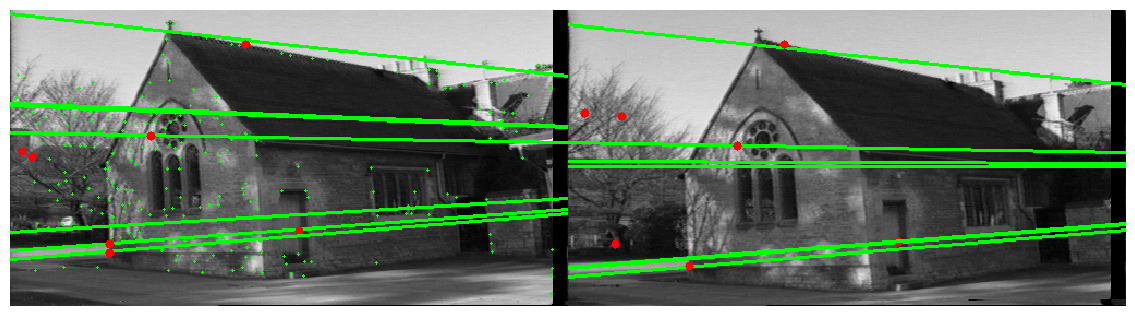

In [535]:
# plot the images with the corresponding epipolar lines
# you may use any plotting library or tool you like

img1 = cv2.imread('Part1_data/chapel00.png')
img2 = cv2.imread('Part1_data/chapel01.png')
# Load Keypoints

print("Normalized Fundamental Matrix F:\n",F_normalized)

# Plot the outlier keypoints with green dots on top of the first image
all_indices = set(range(len(x1)))
# Convert inliers to a set for faster operation
inlier_set = set(inliers)
# Determine the outlier indices by finding the difference
outlier_indices = list(all_indices - inlier_set)

# Draw green dots for outliers on the first image
for idx in outlier_indices:

    img1 = cv2.circle(img1, (int(x1[idx]), int(y1[idx])), 1, (0, 255, 0), -1)

# A possible way:
# 1. Randomly select 7 pairs of points from two images. You can use `np.random.choice()`.
num_points = 7
selected_indices = np.random.choice(len(x1), num_points, replace=False)
selected_x1 = x1[selected_indices]
selected_y1 = y1[selected_indices]
selected_x2 = x2[selected_indices]
selected_y2 = y2[selected_indices]

# 2. Compute epipolar lines for selected points.
# Recall how we represent a line above
lines1 = F_normalized.T @ np.column_stack((selected_x2, selected_y2,np.ones_like(selected_x2))).T
lines1 = lines1.T

lines2 =  F_normalized @ np.column_stack((selected_x1, selected_y1,np.ones_like(selected_x1))).T
lines2 = lines2.T

# 3. Draw lines and points for selected points
# See example in Overview above.
# You can use cv2.line() and cv2.circle().
for r, r1, pt1, pt2 in zip(lines2, lines1, zip(selected_x1, selected_y1), zip(selected_x2, selected_y2)):
    color = tuple(np.random.randint(0, 255, 3).tolist())

    # Draw line on img2
    x0, y0 = map(int, [0, -r[2] / r[1]])
    x1, y1 = map(int, [img2.shape[1], -(r[2] + r[0] * img2.shape[1]) / r[1]])
    img2 = cv2.line(img2, (x0, y0), (x1, y1), (0, 255, 0),2)
    # Draw line on img1
    x0, y0 = map(int, [0, -r1[2] / r1[1]])
    x1, y1 = map(int, [img1.shape[1], -(r1[2] + r1[0] * img1.shape[1]) / r1[1]])
    img1 = cv2.line(img1, (x0, y0), (x1, y1), (0, 255, 0), 2)

    # Draw points on img1 and img2
    img1 = cv2.circle(img1, (int(pt1[0]), int(pt1[1])), 4, (256, 0, 0), -1)
    img2 = cv2.circle(img2, (int(pt2[0]), int(pt2[1])), 4, (256, 0, 0), -1)



# 4. Show two images side by side.
# You can use `np.concatenate()`.
result = np.concatenate((img1, img2), axis=1)
show_image(result,scale=3)


# Part 2: Image stitching (30 points)

<img src="https://www.cs.umd.edu/class/spring2023/cmsc426-0201/hw_images/image_stitching.png" width="800"/>

## Overview

In this problem, you will implement an algorithm for automatically estimating the fundamental matrix F using RANSAC and the normalized 8-point algorithm.

Image Stitching Algorithm Overview
1. Detect keypoints
2. Match keypoints
3. Estimate homography with matched keypoints (using RANSAC)
4. Combine images

**Note:**  Do not use existing image stitching code, such as found on the web, and OpenCV.

## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [536]:
# # Download Data -- run this cell only one time per runtime
# !gdown 1fnD0hJ8-_Rngsc-m96ghKtdZAMf0VTjy
# !unzip "/content/hill.zip" -d "/content/hill"

# !gdown 1v2BFVMV0McuD5BstLvDmo1U9MrFAByS5
# !unzip "/content/tv.zip" -d "/content/tv"


### Hint


*   Use SIFT to find keypoint. You can use sift.detectAndCompute in opencv.
*   For image warping and blending, you should first deterimne canvas size. You can use cv2.warpPerspective in opencv.

An example is as follows:

<img src="https://www.cs.umd.edu/class/spring2024/cmsc426-0101/img/stitch.jpg" width="800"/>




## Helper Functions

In [537]:
import cv2

def drawMatches(image1, kp1, image2, kp2, idx_pairs):
    keypt1 = [cv2.KeyPoint(coord[1], coord[0], 40) for coord in kp1.tolist()]
    keypt2 = [cv2.KeyPoint(coord[1], coord[0], 40) for coord in kp2.tolist()]
    matches = [cv2.DMatch(pair[0], pair[1], 0) for pair in idx_pairs.tolist()]
    return cv2.drawMatches(image1, keypt1, image2, keypt2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

def plot_matches(images, feature_coord, matches, img_idx):
    matched_img = drawMatches(images[img_idx], feature_coord[img_idx], images[img_idx-1],
                              feature_coord[img_idx-1], matches[img_idx-1])

    cv2.imshow('Matches Found', matched_img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

def est_homography(src, dest):
    N = src.shape[0]
    if N != dest.shape[0]:
        raise ValueError("src and diff should have the same dimension")
    src_h = np.hstack((src, np.ones((N, 1))))
    A = np.array([np.block([[src_h[n], np.zeros(3), -dest[n, 0] * src_h[n]],
                            [np.zeros(3), src_h[n], -dest[n, 1] * src_h[n]]])
                  for n in range(N)]).reshape(2 * N, 9)
    [_, _, V] = np.linalg.svd(A)
    return V.T[:, 8].reshape(3, 3)

def apply_homography(H, src):
    src_h = np.hstack((src, np.ones((src.shape[0], 1))))
    dest =  src_h @ H.T
    return (dest / dest[:,[2]])[:,0:2]

### Code (15 pt)

In [538]:
# YOUR CODE HERE:
def crop_dark(panorama):
    gray_panorama = cv2.cvtColor(panorama, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray_panorama, 1, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    max_area_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(max_area_contour)
    panorama = panorama[y:y+h, x:x+w]

    return panorama

def getInliers(src,dest, H, thresh):
    inliers = []

    for i in range(len(src)):
        p1 = np.append(src[i], 1)
        p2_est = H @ p1  # Project src point to destination image using H
        p2_est /= p2_est[2] 

        p2 = np.append(dest[i], 1)

        dist = np.linalg.norm(p2_est[:2] - p2[:2])
        if dist < thresh:
            inliers.append(i)
    return inliers

def compute_H(src,dest):
    A = []
    for p1, p2 in zip(src,dest):
        x1,y1 = p1
        x2,y2 = p2

        A.append([x1, y1, 1, 0, 0, 0, -x2*x1, -x2*y1, -x2])
        A.append([0, 0, 0, x1, y1, 1, -y2*x1, -y2*y1, -y2])
    
    A = np.array(A)
    U, S, Vt = np.linalg.svd(A)
    H = Vt[-1].reshape(3, 3)
    
    return  H / H[2, 2]
    
def find_homography_ransac(src, dest, threshold=0.5, max_iterations=1000):
    """
    Run RANSAC to estimate H.
    Input:
    - src, dest: coordinates
    - threshold: threshold for RANSAC
    - max_iterations: number of iterations for RANSAC
    Output:
    - estimated homography H
    - inliers
    """

    max_inliers = []
    best_H = None
    
    for _ in range(max_iterations):
    #    1. Randomly select 8 points
        indices = np.random.choice(len(src), 4, replace=False)
        pts1 = src[indices]
        pts2 = dest[indices]
    #    2. Call computeF()
        H = compute_H(pts1, pts2) 
    #    3. Call getInliers()
        inliers = getInliers(src, dest, H, threshold)

    #    4. Update F and inliers.
        if len(inliers) > len(max_inliers):
            max_inliers = inliers
            best_H = H

    return best_H, inliers



def stitch_images(img1, img2,  threshold=0.5):
    """
    Stitch two images at a time.
    Inputs:
    - img1, img2 with shape [H, W, 3].
    Output:
    - stitched_image with shape [H, W, 3].
    """
    #1. Detect keypoints
    # SIFT feature detection and matching
    # You can use sift.detectAndCompute() from cv2

    sift = cv2.SIFT_create()
    keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(img2, None)

    #2. Match keypoints
    # hint: You will need to create descriptors. One way to do that is to use
    # sift. You can use SIFT from opencv (cv2) for that
    # or you can use your preferred method of creating descriptors
    # KNN can be useful to match points, use e.g., cv2.FlannBasedMatcher()
    # You can further filter out some matches by using a threshold.
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50) 

    flann = cv2.FlannBasedMatcher(index_params,search_params)
    matches = flann.knnMatch(descriptors1,descriptors2,k=2)

    good_matches = [m for m, n in matches if m.distance < 0.7 * n.distance]

    matches1 = np.float32([keypoints1[m.queryIdx].pt for m in good_matches])
    matches2 = np.float32([keypoints2[m.trainIdx].pt for m in good_matches])

    #3. Estimate homography with matched keypoints (using RANSAC)
    # Call `find_homography_ransac()`

    H,inliers = find_homography_ransac(matches1, matches2,  threshold= threshold)

    # H, _ = cv2.findHomography(matches1, matches2)
    
    print("best homography H after RANSAC\n",H)
    # print(len(inliers))
    def calculate_translation(src, dest, H, inliers):
        """
        Calculate average translation based on inliers and homography matrix.
        """
        total_translation = np.array([0.0, 0.0])  # Ensure floating-point type
        inlier_count = 0

        for i in inliers:
            src_pt = np.append(src[i], 1)  # Convert to homogeneous coordinates
            dest_pt = np.append(dest[i], 1)

            transformed_pt = H @ src_pt
            transformed_pt /= transformed_pt[2]  # Convert from homogeneous to Cartesian coordinates

            translation = dest_pt[:2] - transformed_pt[:2]
            total_translation += translation[:2]
            inlier_count += 1

        average_translation = total_translation / inlier_count if inlier_count > 0 else total_translation
        return average_translation

    #4. Combine images
    # Here we assume all the images are ordered, from left to right: "1.jpg,
    # 2.jpg, 3.jpg...". You can use `cv2.warpPerspective()` to warp images.
    # Be careful: do we use forward warping or inverse warping?
    # You probably want to crop out some dark part. Call crop_dark() above.
    # Determine the size of the panorama
    h1, w1, _ = img1.shape
    h2, w2, _ = img2.shape
    panorama_width = w1 + w2
    panorama_height = max(h1, h2)

    translation_vec = calculate_translation(matches1, matches2, H, inliers)
    translation_matrix = np.array([[1, 0, translation_vec[0]+w1], [0, 1, translation_vec[1]], [0, 0, 1]])
    H = np.dot(translation_matrix, H)  # Adjust H to shift the image to the right

    stitched_image = cv2.warpPerspective(img1, H, (panorama_width, panorama_height))
    stitched_image[0:h1, w1:] = img2
    stitched_image = crop_dark(stitched_image)

    return stitched_image

['hill/1.JPG', 'hill/2.JPG', 'hill/3.JPG']


best homography H after RANSAC
 [[ 1.11434679e+00 -1.36343411e-02 -1.51632515e+02]
 [ 6.03005979e-02  1.06770599e+00  8.26462823e+00]
 [ 3.09602887e-04 -4.72085224e-05  1.00000000e+00]]


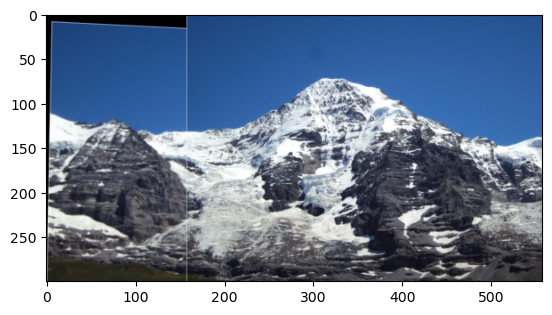

In [539]:
# Let's first try two images.
import glob
case_name = "hill"
imgs_path =  case_name
img_list = sorted(glob.glob(os.path.join(imgs_path, "*.JPG"))) + sorted(glob.glob(os.path.join(imgs_path, "*.jpg")))
print(img_list)


# Try first two images
img1 = cv2.imread(img_list[1])
img2 = cv2.imread(img_list[2])

stitched_12 = stitch_images(img1, img2)

# display stitched image

plt.imshow(stitched_12[:, :, [2,1,0]])

best homography H after RANSAC
 [[ 1.12795379e+00 -5.69556251e-02 -1.64247766e+02]
 [ 1.11280003e-01  1.07711467e+00 -4.19898532e+00]
 [ 3.56116688e-04 -6.31652197e-05  1.00000000e+00]]
best homography H after RANSAC
 [[ 1.17928757e+00 -1.43934596e-02 -3.77444852e+02]
 [ 6.32483623e-02  1.12960334e+00 -2.57815949e+00]
 [ 3.25205202e-04 -5.14870628e-05  1.00000000e+00]]


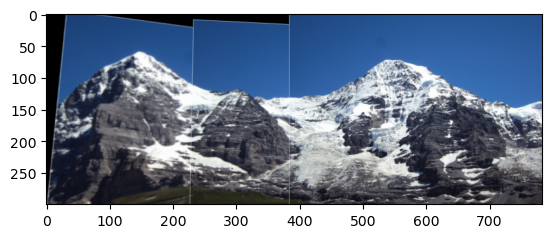

In [540]:
# Now let's stitch all three images in `hill`.
# Hint: you can stitch the last two images `2.JPG` and `3.JPG`
# and then stitch `1.JPG` with stitched `2.JPG` + `3.JPG`.
case_name = "hill"
imgs_path =  case_name
img_list = sorted(glob.glob(os.path.join(imgs_path, "*.JPG"))) + sorted(glob.glob(os.path.join(imgs_path, "*.jpg")))


# Try first two images
img1 = cv2.imread(img_list[0])
img2 = cv2.imread(img_list[1])

stitched_12 = stitch_images(img1, img2)
stitched = stitch_images(stitched_12,cv2.imread(img_list[2]))

# display stitched image

plt.imshow(stitched[:, :, [2,1,0]])

best homography H after RANSAC
 [[ 1.53542101e+00  2.29450077e-02 -4.13416209e+02]
 [ 3.37268790e-01  1.40295021e+00 -1.25971318e+02]
 [ 1.11865370e-03 -7.69662995e-06  1.00000000e+00]]
best homography H after RANSAC
 [[ 2.23396968e+00  1.60042395e-02 -1.38940697e+03]
 [ 4.21027029e-01  2.07252370e+00 -3.25877274e+02]
 [ 1.36775007e-03  6.69416355e-05  1.00000000e+00]]


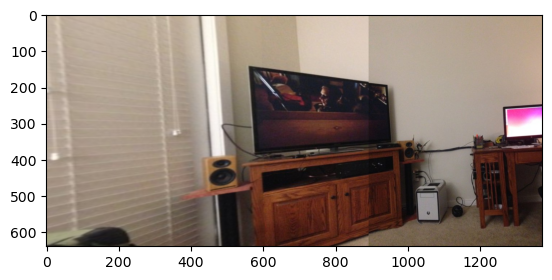

In [543]:
# Now stitch images for `tv`.
# Try some different hyperparameters,
# such as thresh in keypoint match, or error thresh in RANSAC.
case_name = "tv"
imgs_path =  case_name
img_list = sorted(glob.glob(os.path.join(imgs_path, "*.JPG"))) + sorted(glob.glob(os.path.join(imgs_path, "*.jpg")))


# Try first two images
img1 = cv2.imread(img_list[0])
img2 = cv2.imread(img_list[1])

stitched_12 = stitch_images(img1, img2,threshold= 1)
stitched = stitch_images(stitched_12,cv2.imread(img_list[2]),threshold= 0.3)

# display stitched image

plt.imshow(stitched[:, :, [2,1,0]])

### Write-up (15 pt)
*  Describe how to remove incorrect matches with RANSAC

To remove incorrect matches with RANSAC,4 pairs of matches is randomly selected to estimate the homography matrix, and then the model is used to identify inliers based on a predefined distance threshold. This process is repeated multiple times, and the model with the highest number of inliers is selected as the best fit, effectively filtering out incorrect matches or outliers.
*  Display the best homography H after RANSAC (We recommend normalizing `H` by `H = H / H[2, 2]`)
*  Display the blended images